In [1]:
#%% Package imports

# Install the Python control library
# %pip install -q control

# Numerical and CVXPY packages
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import andes
from sippy_unipi import system_identification as sysid
import casadi as ca
import pandas as pd
# from control import ss


# Plotting
%matplotlib widget
import matplotlib.pyplot as plt
# %config InlineBackend.figure_format = 'svg'
plt.style.use('tableau-colorblind10')

# Configuration
np.random.seed(0)  # For reproducibility

In [2]:
# Setup Simulation:
andes.config_logger(stream_level=50)
data_sys = andes.run('ieee14.xlsx', default_config=True)
data_sys.TDS.config.diagnose = 1
data_sys.TDS.config.verbose = 2
data_sys.TDS.config.criteria = 0
data_sys.TDS.config.tstep = 0.01

# Configure PQ loads so they are controllable. Setting these params is required to change loads during simulation
data_sys.PQ.config.p2p = 1.0
data_sys.PQ.config.p2i = 0
data_sys.PQ.config.p2z = 0

data_sys.PQ.config.q2q = 1.0
data_sys.PQ.config.q2i = 0
data_sys.PQ.config.q2z = 0

-> Single process finished in 0.5340 seconds.


In [36]:
## Config for data collection
dt = 0.05									# Sampling time in seconds
T = 620										# Number of data points
tf_data_collection = dt*T					# Final time in seconds
t_data_collection = np.arange(
    0, tf_data_collection, dt)				# Time vector

# Control parameters
N = 5											# Prediction horizon for DeepC and MPC
p = data_sys.Bus.Vn.n    						# Number of outputs (one per bus)
num_controllable_loads = data_sys.PQ.Vn.n		# Number of controllable loads
m = num_controllable_loads * 2					# Number of inputs (P and Q per controllable load)
controllable_loads = data_sys.PQ.idx.v

Q = np.eye(p) * 10		# Input penalty matrix for MPC
R = np.eye(m) * 0.1		# Output penalty matrix for MPC


## 1) Collect IO dataset

In [4]:

data_sys.TDS.config.tf = tf_data_collection

# Generate random input perturbations
u_pe = np.random.standard_normal((len(t_data_collection), m)) * 0.01
# u_pe = np.zeros((len(t_data_collection), m))
# u_pe[1, :] = 0.5 * (2 * np.random.rand(m) - 1)

# Add base values to inputs
PQ_base = np.empty(m)
PQ_base[0::2] = data_sys.PQ.Ppf.v.copy()
PQ_base[1::2] = data_sys.PQ.Qpf.v.copy()
u_pe += PQ_base

# Determine steady state y to stabilize
y_base = data_sys.Bus.v.v.copy()

# Preallocate storage for outputs and inputs
ys = np.zeros((len(t_data_collection), p))
us = np.zeros((len(t_data_collection), m))

# Iterate through simulation
for i, t in enumerate(t_data_collection[:-1]):
	# Store w(t)
	ys[i, :] = data_sys.Bus.v.v.copy() - y_base
	us[i, :] = u_pe[i, :].copy() - PQ_base

	# Apply inputs
	for j, load_idx in enumerate(controllable_loads):
		data_sys.PQ.Ppf.v[j] = u_pe[i, j*2]
		data_sys.PQ.Qpf.v[j] = u_pe[i, j*2+1]

	# Run simulation for one time step
	data_sys.TDS.config.tf = t_data_collection[i+1]
	data_sys.TDS.run()
	print(f"Completed simulation step {i+1} of {len(t_data_collection)-1}", end='\r')

	
ys[-1, :] = data_sys.Bus.v.v.copy() - y_base
us[-1, :] = u_pe[-1, :].copy() - PQ_base

# Clear output. I can't figure out how to suppress the loading bar so this is a workaround.
from IPython.display import clear_output
clear_output()

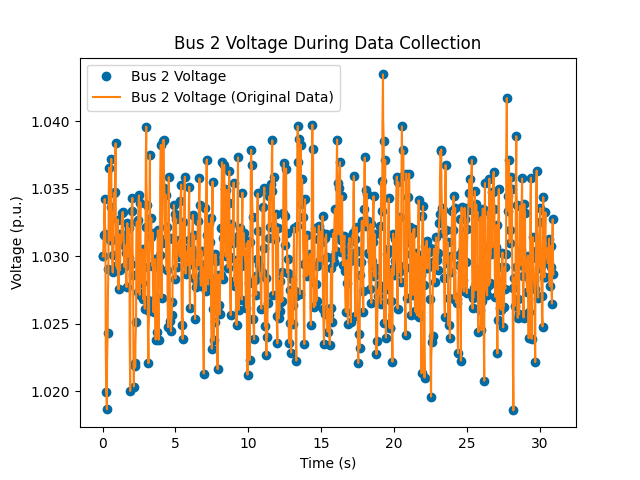

In [5]:
# Inspect a random bus (bus 2) voltage to see how it evolves throughout the simulation

data_sys.dae.ts.unpack(df=True)
df = data_sys.dae.ts.df.copy()

# Resample df to match t_data_collection
df2 = df.reindex(t_data_collection, method='nearest')

fig1, ax1 = plt.subplots()
ax1.plot(t_data_collection, df2.iloc[:, 81], linestyle='', marker='o', label='Bus 2 Voltage')
# ax1.step(t_data_collection, df2.iloc[:, 81], label='Bus 2 Voltage')
ax1.plot(df.iloc[:, 81], label='Bus 2 Voltage (Original Data)')

# Save at MATPLOTLIB figure
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (p.u.)')
ax1.set_title('Bus 2 Voltage During Data Collection')
ax1.legend()


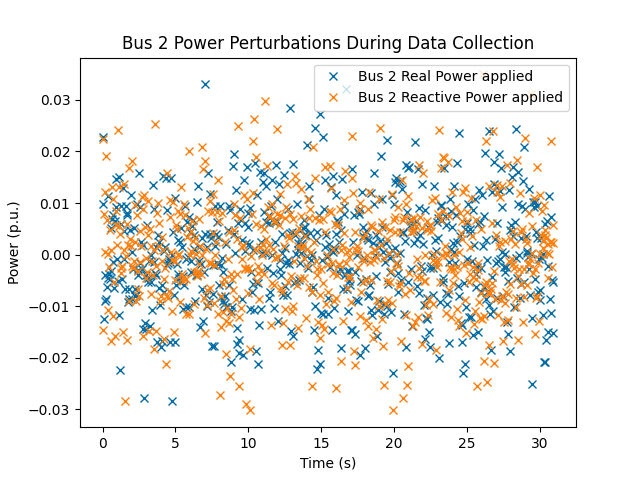

In [6]:
fig2, ax2 = plt.subplots()

ax2.plot(t_data_collection, us[:, 2], linestyle='', marker='x', label='Bus 2 Real Power applied')
ax2.plot(t_data_collection, us[:, 3], linestyle='', marker='x', label='Bus 2 Reactive Power applied')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Power (p.u.)')
ax2.set_title('Bus 2 Power Perturbations During Data Collection')
ax2.legend()


In [7]:
# Construct Hankel Matrices

def block_hankel(blocks, L):
	"""
	Construct a block Hankel matrix from an array of vectors.

	Parameters
	----------
	blocks : np.ndarray
		Array of vectors [v1, v2, ..., v_{T}]
		blocks.shape = (p, T)
	L : int
		Number of block rows.

	Returns
	-------
	H : np.ndarray
		Block Hankel matrix of shape (L*p, T-L+1).
	"""

	p = blocks.shape[0]  # Dimension of each vector
	T = blocks.shape[1]  # Total number of vectors

	# --- Construct Hankel matrix ---
	H = np.zeros((L * p, T - L + 1))
	for i in range(L):
		H[i*p:(i+1)*p, :] = blocks[:, i:i+T-L+1]

	return H




Text(0.5, 1.0, 'Singular Values of Hankel Matrix (First Omitted)')

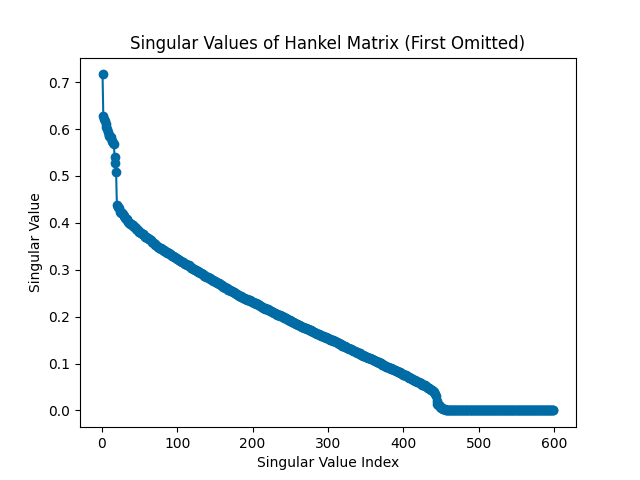

In [8]:
# Inspect singular values of Hankel matrices

L_est = 20									# Rough estimate, will refine later
Hy_est = block_hankel(ys[1:, :].T, L_est)
Hu_est = block_hankel(us[1:, :].T, L_est)

H_est = np.vstack((Hu_est,Hy_est))

# SVD on Hankel matrix
U, S, Vh = np.linalg.svd(H_est, full_matrices=False)

# Plot singular values
fig3, ax3 = plt.subplots()
ax3.plot(np.arange(1, len(S)), S[1:], marker='o')
ax3.set_xlabel('Singular Value Index')
ax3.set_ylabel('Singular Value')
ax3.set_title('Singular Values of Hankel Matrix (First Omitted)')

From the above plot, we can see that the apparent "elbow" is at r ~= 15. This tracks with the fact that the IEEE14 bus system has 5 synchronous generators, each with 3 dynamial states (2 for angular dynamics, 1 for exciter dynamics) for a total of 15 dyanmical states. For future studies, we will assume n=15

Text(0.5, 1.0, 'Minimum Singular Value vs Hankel Window Length')

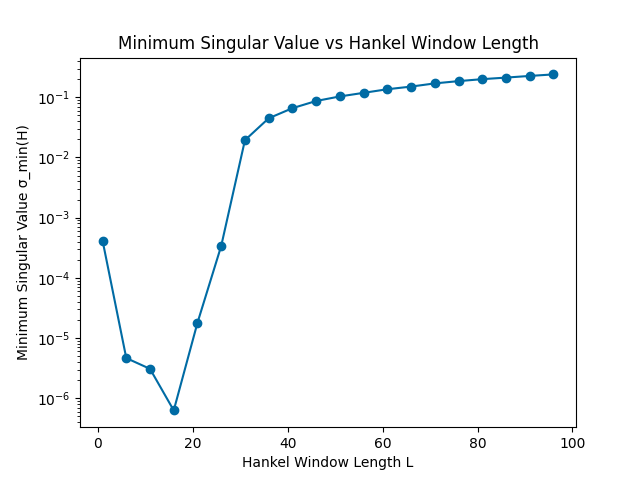

In [9]:
# Now determine the approximate lag. We will compute sigma_min(H) for increasing L and look for the plateau

sigma_mins = []
L_max = 100

for L_test in range(1, L_max, 5):
    H_y_test = block_hankel(ys.T, L_test)
    H_u_test = block_hankel(us.T, L_test)
    H_test = np.vstack((H_u_test, H_y_test))
    sigmas = np.linalg.svdvals(H_test)
    sigma_mins.append(sigmas[-1])
    
# Plot sigma_min vs L
fig4, ax4 = plt.subplots()
ax4.semilogy(range(1, L_max, 5), sigma_mins, marker='o')
ax4.set_xlabel('Hankel Window Length L')
ax4.set_ylabel('Minimum Singular Value σ_min(H)')
ax4.set_title('Minimum Singular Value vs Hankel Window Length')

    

From this plot, it looks like the plateau starts to occur around L=30. Ideally, we would pick the lag as 30, but for computational efficiency we choose T_ini=7

In [37]:
n = 15  	# Chosen system order based on singular value analysis
T_ini = 7	# Chosen initial trajectory length based on estimated lag
L = N + T_ini										# Hankel window length

Hy = block_hankel(ys.T, L)
Hu = block_hankel(us.T, L)
H = np.vstack((Hu,Hy))

U_p = Hu[:m*T_ini, :]
U_f = Hu[m*T_ini:, :]
Y_p = Hy[:p*T_ini, :]
Y_f = Hy[p*T_ini:, :]

# Input constraint matrix
G_bar = np.kron(np.eye(N*m), np.array([[1], [-1]]))
saturation_limit = 0.05
g_bar = np.kron(np.ones((2*N*m, 1)), saturation_limit)

# Cost matrices
Q_bar = np.kron(np.eye(N), Q)
R_bar = np.kron(np.eye(N), R)

cost_matrix = Y_f.T @ Q_bar @ Y_f + U_f.T @ R_bar @ U_f

lambda_s = 1e5
lambda_g = 200

# Init optimization variable
g_var = cp.Variable((T-T_ini-N+1, 1))
sigma = cp.Variable((p * T_ini, 1))




In [40]:
def deepc_control(y_ini, u_ini):
	constraints = []

	# Define the constraints
	constraints += [Y_p @ g_var == y_ini.reshape(-1, 1) + sigma]
	constraints += [U_p @ g_var == u_ini.reshape(-1, 1)]

	constraints += [G_bar @ U_f @ g_var <= g_bar]

	# Define the cost function
	cost = 0
	cost += cp.quad_form(g_var, cp.psd_wrap(cost_matrix))
	cost += lambda_s * cp.sum_squares(sigma)
	cost += lambda_g * cp.sum_squares(g_var)

	# Define and solve the optimization problem
	prob = cp.Problem(cp.Minimize(cost), constraints)
	prob.solve(solver=cp.OSQP)

	# Return the first control input
	if g_var.value is not None and sigma.value is not None:
		u = (U_f @ g_var.value)[0:m].flatten()
		print(f"DeePC control: {u}")
		print(F"Sigma norm: {np.linalg.norm(sigma.value, 1)}")
		print(f"g_var norm: {np.linalg.norm(g_var.value, 1)}")
		return u
	
	else:
		print("DeePC problem is infeasible.")
		return np.zeros((m,1))  # Fallback control input if problem is infeasible

## Part 1.5: Unactuated system for comparison

In [44]:
# Setup Simulation:
andes.config_logger(stream_level=50)
test_sys = andes.run('ieee14_test.xlsx', default_config=True)
test_sys.TDS.config.diagnose = 1
test_sys.TDS.config.verbose = 2
test_sys.TDS.config.criteria = 0
test_sys.TDS.config.tstep = 0.01

# Configure PQ loads so they are controllable. Setting these params is required to change loads during simulation
test_sys.PQ.config.p2p = 1.0
test_sys.PQ.config.p2i = 0
test_sys.PQ.config.p2z = 0

test_sys.PQ.config.q2q = 1.0
test_sys.PQ.config.q2i = 0
test_sys.PQ.config.q2z = 0

## Config for test
tf_test = 8.0					# Final time in seconds
t_test = np.arange(
    0, tf_test, dt)				# Time vector

test_sys.TDS.config.tf = tf_test

u_ini = np.zeros((m, T_ini))
y_ini = np.zeros((p, T_ini))

# Preallocate storage for outputs and inputs
ys_test = np.zeros((len(t_test), p))
us_test = np.zeros((len(t_test), m))

# Iterate through simulation
for i, t in enumerate(t_test[:-1]):
	# Update ys, y_ini
	ys_test[i, :] = test_sys.Bus.v.v.copy()

	# Update us, u_ini
	us_test[i, :] = PQ_base

	# Apply inputs
	for j, load_idx in enumerate(controllable_loads):
		test_sys.PQ.Ppf.v[j] = us_test[i, j*2]
		test_sys.PQ.Qpf.v[j] = us_test[i, j*2+1]

	# Run simulation for one time step
	test_sys.TDS.config.tf = t_test[i+1]
	test_sys.TDS.run()
	print(f"Completed simulation step {i+1} of {len(t_test)-1}", end='\r')

	
ys_test[-1, :] = test_sys.Bus.v.v.copy()
us_test[-1, :] = us_test[-1, :].copy()

# Clear output. I can't figure out how to suppress the loading bar so this is a workaround.
from IPython.display import clear_output
clear_output()

Text(0.5, 1.0, 'Bus Voltages During No Control')

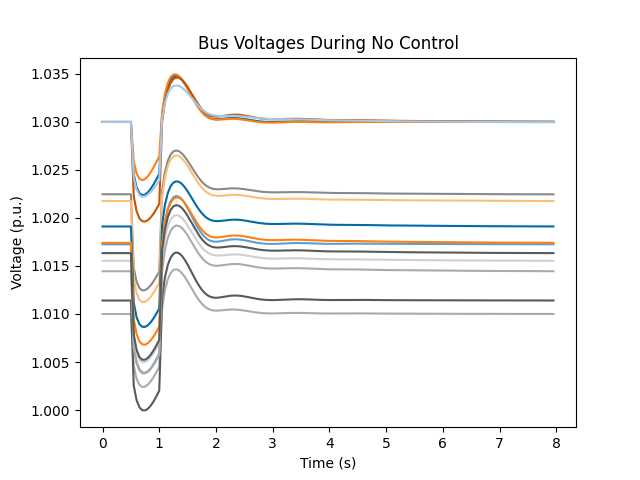

In [45]:
# Visualize voltage at each bus over the simulation
fig6, ax6 = plt.subplots()
for bus_idx in range(data_sys.Bus.n):
	ax6.plot(t_test, ys_test[:, bus_idx], label=f'Bus {bus_idx+1} Voltage')

ax6.set_xlabel('Time (s)')
ax6.set_ylabel('Voltage (p.u.)')
ax6.set_title('Bus Voltages During No Control')

## Part 2: Apply DeePC

In [39]:
# Setup Simulation:
andes.config_logger(stream_level=50)
deepc_sys = andes.run('ieee14_test.xlsx', default_config=True)
deepc_sys.TDS.config.diagnose = 1
deepc_sys.TDS.config.verbose = 2
deepc_sys.TDS.config.criteria = 0
deepc_sys.TDS.config.tstep = 0.01

# Configure PQ loads so they are controllable. Setting these params is required to change loads during simulation
deepc_sys.PQ.config.p2p = 1.0
deepc_sys.PQ.config.p2i = 0
deepc_sys.PQ.config.p2z = 0

deepc_sys.PQ.config.q2q = 1.0
deepc_sys.PQ.config.q2i = 0
deepc_sys.PQ.config.q2z = 0

## Config for deepc
tf_deepc = 8.0					# Final time in seconds
t_deepc = np.arange(
    0, tf_deepc, dt)				# Time vector

deepc_sys.TDS.config.tf = tf_deepc

u_ini = np.zeros((m, T_ini))
y_ini = np.zeros((p, T_ini))

# Preallocate storage for outputs and inputs
ys_dpc = np.zeros((len(t_deepc), p))
us_dpc = np.zeros((len(t_deepc), m))

# Iterate through simulation
for i, t in enumerate(t_deepc[:-1]):
	# Update ys, y_ini
	ys_dpc[i, :] = deepc_sys.Bus.v.v.copy()
	y_ini[:, :-1] = y_ini[:, 1:]
	y_ini[:, -1] = deepc_sys.Bus.v.v.copy() - y_base

	# Update us, u_ini
	us_dpc[i, :] = deepc_control(y_ini, u_ini).copy() + PQ_base
	u_ini[:, :-1] = u_ini[:, 1:]
	u_ini[:, -1] = us_dpc[i, :].copy() - PQ_base

	# Apply inputs
	for j, load_idx in enumerate(controllable_loads):
		deepc_sys.PQ.Ppf.v[j] = us_dpc[i, j*2]
		deepc_sys.PQ.Qpf.v[j] = us_dpc[i, j*2+1]

	# Run simulation for one time step
	deepc_sys.TDS.config.tf = t_deepc[i+1]
	deepc_sys.TDS.run()
	print(f"Completed simulation step {i+1} of {len(t_deepc)-1}", end='\r')

	
ys_dpc[-1, :] = deepc_sys.Bus.v.v.copy()
us_dpc[-1, :] = us_dpc[-1, :].copy()

# Clear output. I can't figure out how to suppress the loading bar so this is a workaround.
from IPython.display import clear_output
clear_output()

Text(0.5, 1.0, 'Bus Voltages During DeePC Control')

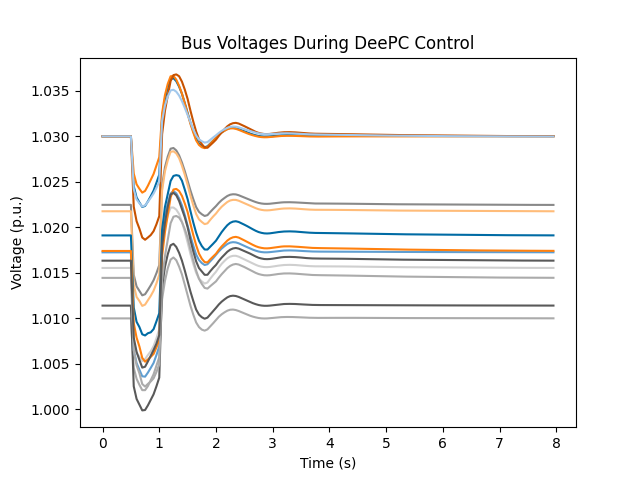

In [43]:
# Visualize voltage at each bus over the simulation
fig5, ax5 = plt.subplots()
for bus_idx in range(data_sys.Bus.n):
	ax5.plot(t_deepc, ys_dpc[:, bus_idx], label=f'Bus {bus_idx+1} Voltage')

ax5.set_xlabel('Time (s)')
ax5.set_ylabel('Voltage (p.u.)')
ax5.set_title('Bus Voltages During DeePC Control')

